

Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pwd


'/content'

Define the working directory

In [ ]:
WORKING_PATH = '/content/drive/MyDrive/NLP practicas/Project'

In [ ]:
%cd {WORKING_PATH}

/content/drive/MyDrive/NLP practicas/Project


In [ ]:
ls

'Automotive NLP Practicas.ipynb'      Datasets/
'Baby NLP Practicas.ipynb'           'Práctica final NLP.pdf'
'Copia de Baby NLP Practicas.ipynb'   results/


## Data Loading

In [ ]:
import json

def load_amazon_reviews(path, sample_size=None):

  data = []
  bad = 0

  with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
      try:
        review = json.loads(line)
      except json.JSONDecodeError:
          bad += 1
          continue

      data.append({
      "review": review["reviewText"],
      "rating": review["overall"]
      })

      if sample_size and i + 1 >= sample_size:
        break
    print("Bad lines:", bad)
    return data

In [ ]:
reviews = load_amazon_reviews("Baby_5.json", sample_size=100000)
print("Number of reviews:", len(reviews))
print("Primera review:")
print(reviews[0])


Bad lines: 0
Number of reviews: 100000
Primera review:
{'review': "Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!", 'rating': 5.0}


In [ ]:
import pandas as pd
df = pd.DataFrame(reviews)


In [ ]:
df.dropna(subset=['review', 'rating'], inplace=True)  #quitar valores nulos
df.reset_index(drop=True, inplace=True)  #resetear indice

# Exploratory Data Analysis

In [ ]:
df.head()

,review,rating
0,Perfect for new parents. We were able to keep ...,5.0
1,This book is such a life saver. It has been s...,5.0
2,Helps me know exactly how my babies day has go...,5.0
3,I bought this a few times for my older son and...,5.0
4,I wanted an alternative to printing out daily ...,4.0


For an initial exploratory analysis, tokenization is performed using a simple split approach.

In [ ]:
splitted_reviews = df['review'].str.lower().str.split()   #convertir en minuscula y tokenizar con split

In [ ]:
print(splitted_reviews.head())

0    [perfect, for, new, parents., we, were, able, ...
1    [this, book, is, such, a, life, saver., it, ha...
2    [helps, me, know, exactly, how, my, babies, da...
3    [i, bought, this, a, few, times, for, my, olde...
4    [i, wanted, an, alternative, to, printing, out...
Name: review, dtype: object


The output stored in splitted_reviews is a pandas Series in which each element corresponds to a list of tokens (words).

In [ ]:
step1 = splitted_reviews.explode()
step1.head()

,review
0,perfect
0,for
0,new
0,parents.
0,we


In [ ]:
step2 = step1.reset_index(drop=True)
step2.head(10)

,review
0,perfect
1,for
2,new
3,parents.
4,we
5,were
6,able
7,to
8,keep
9,track


In [ ]:
words = step2.rename("word")
words.head()

,word
0,perfect
1,for
2,new
3,parents.
4,we


Distribution of Reviews by Sentiment

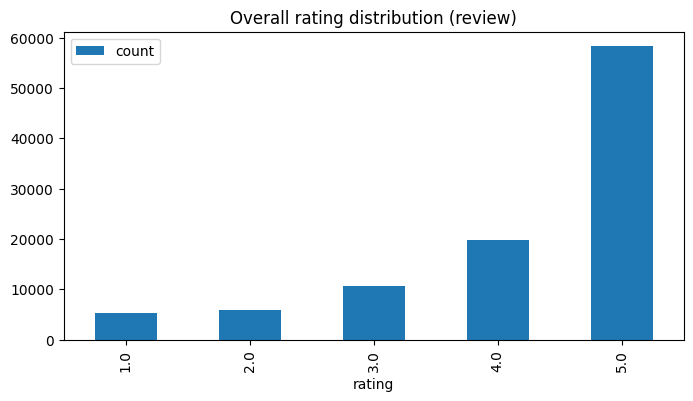

In [ ]:
aux_df = pd.DataFrame(df['rating'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall rating distribution (review)', figsize=(8, 4))

In [ ]:
(df['rating'].value_counts(normalize=True)).round(4)

,proportion
rating,
5.0,0.5827
4.0,0.1991
3.0,0.1069
2.0,0.0590
1.0,0.0523


In [ ]:
#df = df[df["rating"] != 3]  # I believe removing reviews with rating = 3 can be a good practice,
                              # since many of them may be neutral and introduce noise into the model.
                              # During the TF-IDF + SVM training phase, I tested both scenarios
                              # (keeping and removing rating = 3 reviews).
                              # A comparison of the results is provided later.



In [ ]:
def label_sentiment(row):
    if int(row['rating']) <= 3:
        return 0
    else:
        return 1

In [ ]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
df.head()

,review,rating,sentiment_label
0,Perfect for new parents. We were able to keep ...,5.0,1
1,This book is such a life saver. It has been s...,5.0,1
2,Helps me know exactly how my babies day has go...,5.0,1
3,I bought this a few times for my older son and...,5.0,1
4,I wanted an alternative to printing out daily ...,4.0,1


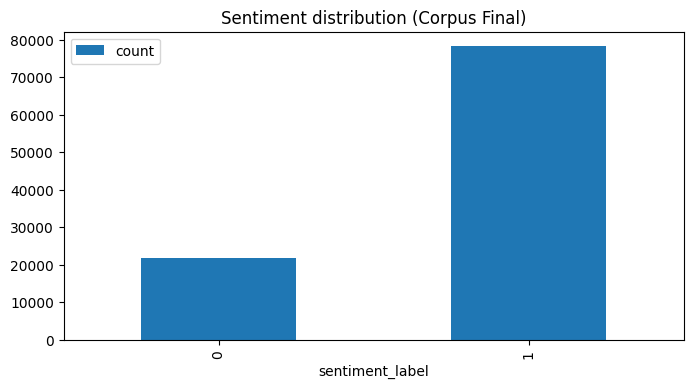

In [ ]:
aux_df = pd.DataFrame(df['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [ ]:
df['sentiment_label'].value_counts(normalize=True)

,proportion
sentiment_label,
1,0.78182
0,0.21818


It can be observed that the dataset is imbalanced.

# Word Cloud

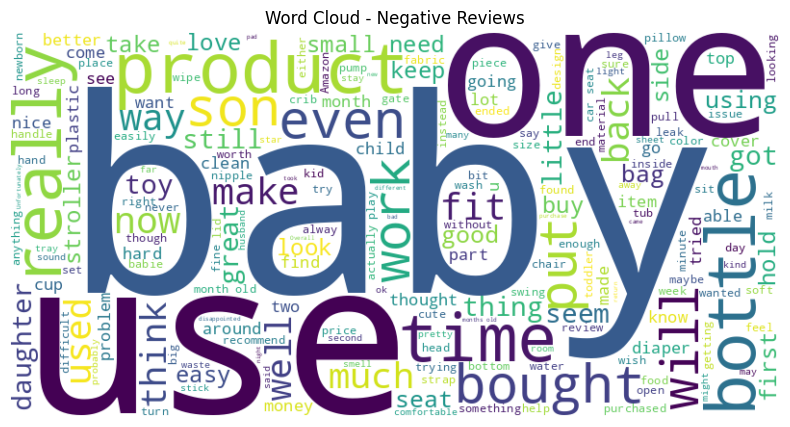

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_text = " ".join(df[df["sentiment_label"] == 0]["review"])

wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()

The negative reviews contain frequent words like one, use, bought, back, work, fit, and problem.

Unlike the positive cloud, emotional words are less prominent. Instead, negative reviews tend to focus on:

-Functional issues (fit, work)

-Product defects or dissatisfaction

-Returns or unmet expectations (back, money)

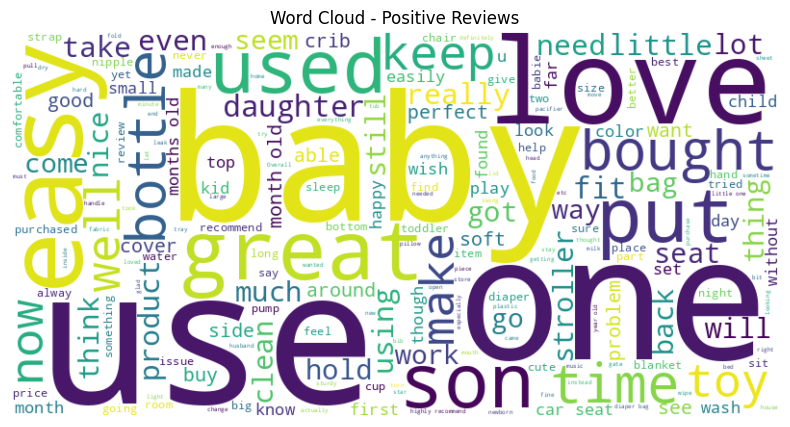

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_text = " ".join(df[df["sentiment_label"] == 1]["review"])

wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")
plt.show()

The positive reviews are dominated by words such as love, great, baby, use, son, and bought.

This suggests that positive feedback focuses on:

-Emotional satisfaction (love, great)

-Successful product usage (use, fit, work)

-Real-life parenting context (baby, son, daughter)

Overall, positive reviews emphasize functionality and satisfaction after purchase.

# Most Frequent N-grams

In [ ]:
from nltk import ngrams, FreqDist

unigrams = ngrams(words, 1)
bigrams = ngrams(words, 2)
trigrams = ngrams(words, 3)

In [ ]:
unigrams_freq = FreqDist(unigrams)
bigrams_freq = FreqDist(bigrams)
trigrams_freq = FreqDist(trigrams)

In [ ]:
unigrams_freq.most_common(10)

[(('the',), 473654),
 (('and',), 284036),
 (('to',), 267218),
 (('i',), 259142),
 (('it',), 223228),
 (('a',), 220592),
 (('is',), 152180),
 (('for',), 130141),
 (('this',), 124658),
 (('of',), 120479)]

In [ ]:
bigrams_freq.most_common(10)

[(('in', 'the'), 36533),
 (('of', 'the'), 33519),
 (('it', 'is'), 26575),
 (('on', 'the'), 26005),
 (('i', 'have'), 18193),
 (('is', 'a'), 17725),
 (('and', 'the'), 17675),
 (('and', 'i'), 17183),
 (('easy', 'to'), 17058),
 (('with', 'the'), 15656)]

In [ ]:
trigrams_freq.most_common(10)

[(('this', 'is', 'a'), 4872),
 (('a', 'lot', 'of'), 4513),
 (('out', 'of', 'the'), 4057),
 (('i', 'bought', 'this'), 3827),
 (('it', 'is', 'a'), 3123),
 (('is', 'a', 'great'), 2723),
 (('you', 'have', 'to'), 2630),
 (('one', 'of', 'the'), 2604),
 (('i', 'love', 'the'), 2583),
 (('be', 'able', 'to'), 2373)]

The most frequent n-grams are mainly stopwords.

## Preprocessing

A text preprocessing function is implemented to remove stopwords, strip punctuation and symbols, and retain only alphabetic characters. As the dataset is in English, no accent normalization is required.

In [ ]:
import re

def sentence_normalization(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r"[^a-z\s]", "", sentence).strip() #Remove non-alphabetic characters
  return sentence

In [ ]:
def remove_stopwords(sentence, sw_list):
  sentence = ' '.join([word for word in sentence.split() if word not in sw_list or word == 'no'])
  return sentence

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') #download list of stopwords
sw_list = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def process_reviews(reviews, sw_list):
    processed_sentences = []
    for sent in df['review']:
        if pd.notna(sent):  # check if sent is not NaN
            sent = sentence_normalization(sent)
            sent = remove_stopwords(sent, sw_list)
            processed_sentences.append(sent)
        else:
            processed_sentences.append('None')
    return processed_sentences

In [ ]:
processed_reviews = process_reviews(df['review'], sw_list)

In [ ]:
processed_reviews[1]

'book life saver helpful able go back track trends answer pediatrician questions communicate different times night newborn think one things everyone required leave hospital went pages newborn version moved infant version finish second infant book third total right baby turns see things must haves baby'

In [ ]:
print('Review original: {}'.format(df['review'].values[0]))
print('Review procesada: {}'.format(processed_reviews[0]))

Review original: Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!
Review procesada: perfect new parents able keep track babys feeding sleep diaper change schedule first two half months life made life easier doctor would ask questions habits right


In [ ]:
df.loc[:, 'processedReview'] = processed_reviews #For all rows in the DataFrame, create or replace the column processedReview and populate it with processed_reviews.

In [ ]:
import numpy as np

df['processedReview'] = df['processedReview'].replace('', np.nan)
df = df.dropna(subset=['processedReview'])

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['processedReview'], df['sentiment_label'], train_size=0.75, test_size=0.25, random_state=42, shuffle=True,stratify=df['sentiment_label'])

In [ ]:
X_train.iloc[:8]

,processedReview
2831,baby monitor amazed pregnant lived tiny apartm...
84345,washed still reeked chemicals also flannel thi...
89592,understand concept appreciate trying get away ...
21405,really loved crib got bought changing table ma...
93441,much smaller expected seem absorbent wont wort...
26577,second child started teething turned none old ...
60659,sheets nice soft thick though thats looking
61306,breastshield really helped make pumping easier...


In [ ]:
y_train.iloc[:8]

,sentiment_label
2831,1
84345,0
89592,0
21405,0
93441,0
26577,1
60659,1
61306,1


In [ ]:
print(sum(y_train))   #Ensure that the stratified split was performed correctly
print(len(y_train))
print(sum(y_train)/len(y_train))

58612
74969
0.7818164841467806


In [ ]:
print(sum(y_test))
print(len(y_test))
print(sum(y_test)/len(y_test))

19538
24990
0.7818327330932373


# Feature Extraction

TfidfVectorizer tokenizes the text, builds a vocabulary from the training corpus, and represents each document as a vector where each term is weighted using TF (term frequency) and IDF (inverse document frequency), which penalizes terms that appear in many documents.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(max_df=0.95, min_df=3, max_features=2500, ngram_range=(1,2))
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, ngram_range=(1, 2))

In the TF-IDF feature extractor, the n-gram range was initially set to (1,3). However, trigrams appeared to introduce additional noise, so the range was reduced to (1,2).

In [ ]:
print(list(cv.vocabulary_.items())[:20])

[('baby', np.int64(129)), ('monitor', np.int64(1336)), ('pregnant', np.int64(1628)), ('tiny', np.int64(2209)), ('apartment', np.int64(88)), ('no', np.int64(1415)), ('need', np.int64(1386)), ('put', np.int64(1683)), ('basic', np.int64(162)), ('inexpensive', np.int64(1067)), ('one', np.int64(1461)), ('could', np.int64(471)), ('find', np.int64(773)), ('registry', np.int64(1755)), ('went', np.int64(2391)), ('grandmas', np.int64(912)), ('house', np.int64(1039)), ('didnt', np.int64(558)), ('high', np.int64(1002)), ('since', np.int64(1921))]


In [ ]:
print(len(cv.vocabulary_))

2500


From Raw Text to TF-IDF Matrix

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Feature Analysis

## $\chi²$ scores


The $\chi^2$ (chi-squared) statistic is used to analyze the relationship between vocabulary terms and the target variable. It helps identify which words and n-grams are most discriminative for sentiment classification.

In [ ]:
from sklearn.feature_selection import chi2

chi2_scores, p_values = chi2(X_train_, y_train)
feature_names = cv.get_feature_names_out()

top_pos = np.argsort(chi2_scores)[-10:]
top_neg = np.argsort(chi2_scores)[:10]

top_features = feature_names[top_pos]
top_features_neg = feature_names[top_neg]



In [ ]:
top_features


array(['great', 'ok', 'easy', 'loves', 'love', 'returned', 'return',
       'waste', 'disappointed', 'waste money'], dtype=object)

It can be observed that the dataset clearly contains sentiment-related signal. Therefore, using a bag-of-words representation is a reasonable approach.

Limitations of the Bag-of-Words approach include its inability to account for word order, its lack of contextual understanding, and the high dimensionality of the resulting feature space.

In [ ]:
top_features_neg

array(['rest', 'touch', 'rattles', 'adjusted', 'wind', 'canopy', 'tubing',
       'breast milk', 'infant seat', 'totally'], dtype=object)

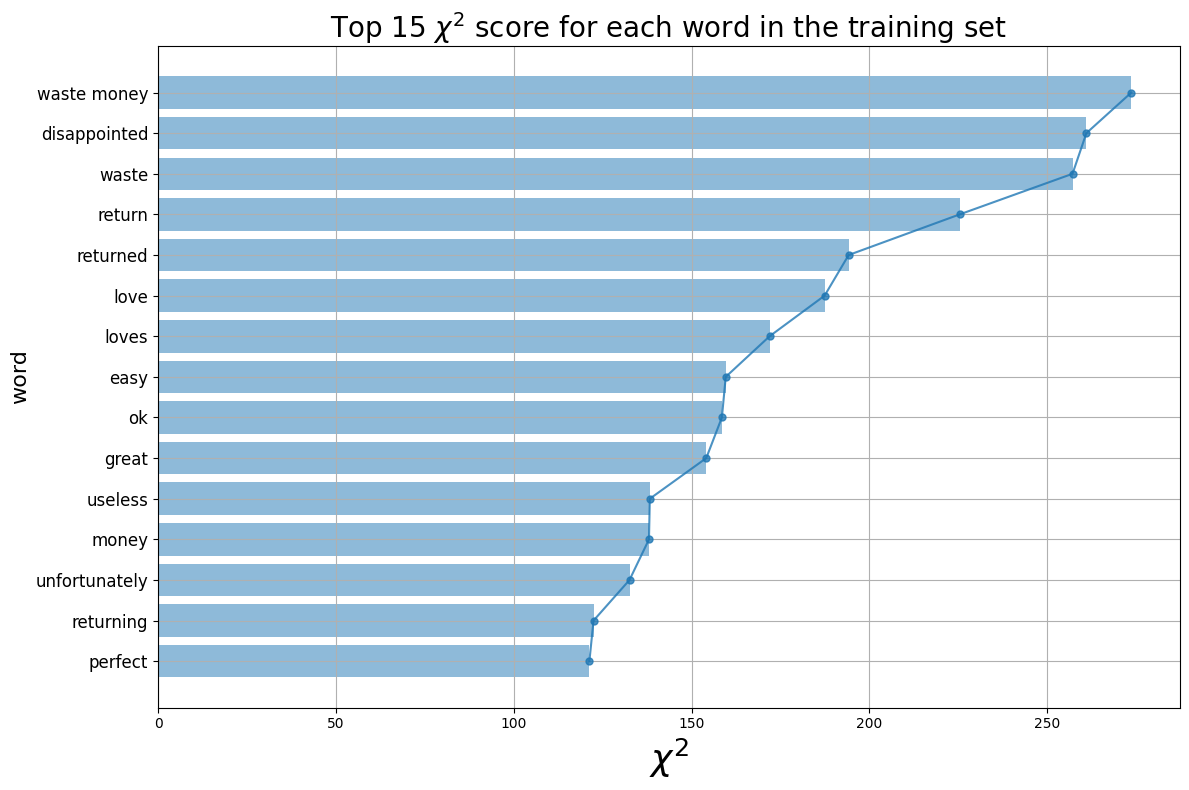

In [ ]:
# Compute the chi-squared score for each word in the training set and show the values

import matplotlib.pyplot as plt

i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel(r'$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title(r'Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

## Train a Classification Model

Here, class_weight="balanced" is used because the dataset is imbalanced. In this way, the model penalizes errors in the minority class more heavily.

Regarding the optimization metric, the scoring parameter was initially set to "f1". It was later changed to "f1_macro" in order to force the model to pay equal attention to both classes, especially the minority class (class 0).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    LogisticRegression(max_iter=500, class_weight="balanced"),
    param_grid={"C": [0.01, 0.1, 1, 10, 100, 1000, 10000]},
    scoring="f1_macro",
    cv=5,
    return_train_score=True
)

grid.fit(X_train_, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=500),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
             return_train_score=True, scoring='f1_macro')

In [ ]:
grid.best_params_


{'C': 1}

In [ ]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results[[
    "param_C",
    "mean_train_score",
    "mean_test_score"
]]


,param_C,mean_train_score,mean_test_score
0,0.01,0.734129,0.729483
1,0.10,0.769747,0.759926
2,1.00,0.794257,0.774886
3,10.00,0.800085,0.773475
4,100.00,0.800910,0.772175
5,1000.00,0.800489,0.773014
6,10000.00,0.800472,0.773095


In [ ]:
best_model = grid.best_estimator_

In [ ]:
from sklearn.metrics import precision_score
import numpy as np

proba_train = best_model.predict_proba(X_train_)[:, 1]
thresholds = np.linspace(0.05, 0.5, 50)
best_t = 0
best_perc0= 0

for t in thresholds:
  y_train_pred = (proba_train >= t).astype(int)
  prec0 = precision_score(y_train, y_train_pred, pos_label=0)
  if prec0 > best_perc0:
    best_prec0 = prec0
    best_t = t
print("Best theshold:", best_t)
print("Precision0 (train):", best_prec0)

Best theshold: 0.5
Precision0 (train): 0.5879994936495211


In [ ]:
y_test_predict = best_model.predict(X_test_)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, y_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_test_predict)))

Confusion matrix:
[[ 4474   978]
 [ 3328 16210]]

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.82      0.68      5452
           1       0.94      0.83      0.88     19538

    accuracy                           0.83     24990
   macro avg       0.76      0.83      0.78     24990
weighted avg       0.86      0.83      0.84     24990

Accuracy score:0.8276910764305723


The model is performing poorly when predicting negative reviews. The precision for class 0 is low because the model predicts too many 0s when the true label should be 1, resulting in a high number of false positives for class 0 (i.e., false negatives for class 1).

Before removing the reviews with rating = 3:

 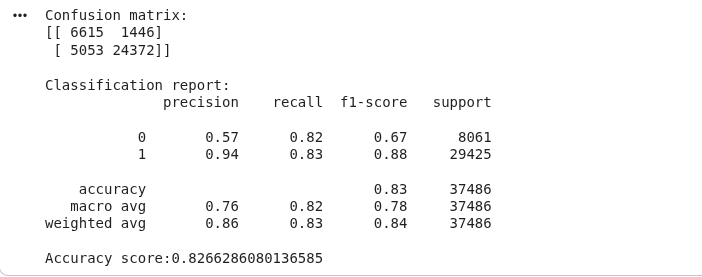

Before Removing 3-Star Reviews:

Accuracy: 0.83

The model performs well on the positive class (F1 = 0.88).

Performance on the negative class is weaker (F1 = 0.67), mainly due to low precision.

The presence of 3-star reviews likely introduces ambiguity, making the boundary between classes less clear.

After removing the reviews with rating=3:
 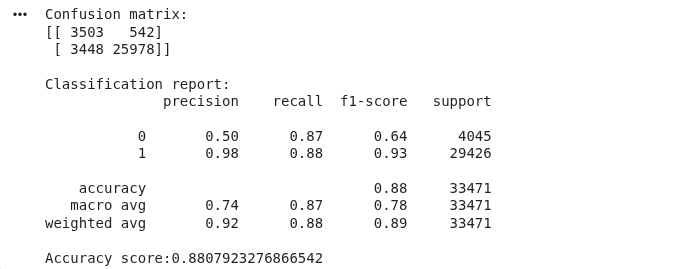

After Removing 3-Star Reviews:

Accuracy increases to 0.88.

Positive class performance improves further (F1 = 0.93).

Negative class performance remains relatively weak (F1 = 0.64).

Removing neutral reviews makes the task easier overall, but the model still struggles with correctly identifying negative reviews.

### Conclusion

Eliminating 3-star reviews improves overall accuracy and strengthens positive predictions, but class imbalance and difficulty in detecting negatives persist.

In [ ]:
y_test_predict = best_model.predict(X_test_)

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_test_predict)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

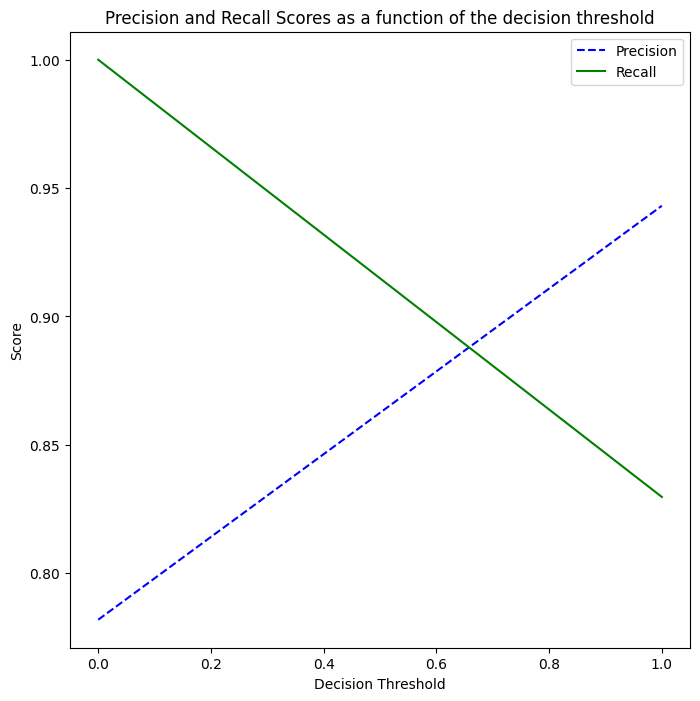

In [ ]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In this graph, a classic precision–recall trade-off can be observed. When the threshold is increased, precision improves because the model only predicts the most confident cases as positive. However, recall decreases since many true positives do not reach such a high threshold.

Therefore:

When the threshold is high: precision is high, but there are many false negatives.

When the threshold is low: recall is high, but there are many false positives.

# Predict

In [ ]:
def predict_review_sentiment(review_index, model):
  print('actual sentiment: {}'.format(df.loc[review_index]['sentiment_label']))
  review = df.iloc[review_index]['review']
  print('prediction: {}'.format(model.predict(cv.transform([review]))))

In [ ]:
import random
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, best_model)


Review no. 76791
actual sentiment: 1
prediction: [1]

Review no. 21699
actual sentiment: 1
prediction: [0]

Review no. 41444
actual sentiment: 1
prediction: [1]

Review no. 31428
actual sentiment: 0
prediction: [1]

Review no. 14620
actual sentiment: 1
prediction: [1]


Although the Baby Products dataset performs better than the Automotive dataset in terms of class balance, it still presents a noticeable imbalance. The limited number of samples in the minority class negatively affects the model’s predictive performance.

As a result, the model struggles to generalize well for the minority class, leading to weaker classification performance for that category.

In [ ]:
def predict_review_sentiment(review_index, model):
    print('actual sentiment: {}'.format(df.loc[review_index]['sentiment_label']))

    review = df.iloc[review_index]['review']
    review_transformed = cv.transform([review])

    prediction = model.predict(review_transformed)
    probability = model.predict_proba(review_transformed)

    print('prediction: {}'.format(prediction[0]))
    print('probability positive: {:.3f}'.format(probability[0][1]))

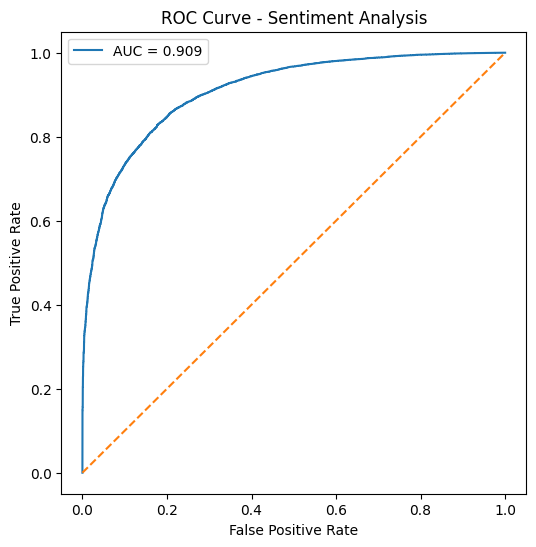

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades
y_scores = best_model.predict_proba(X_test_)[:, 1]

# Calcular ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Sentiment Analysis')
plt.legend()
plt.show()

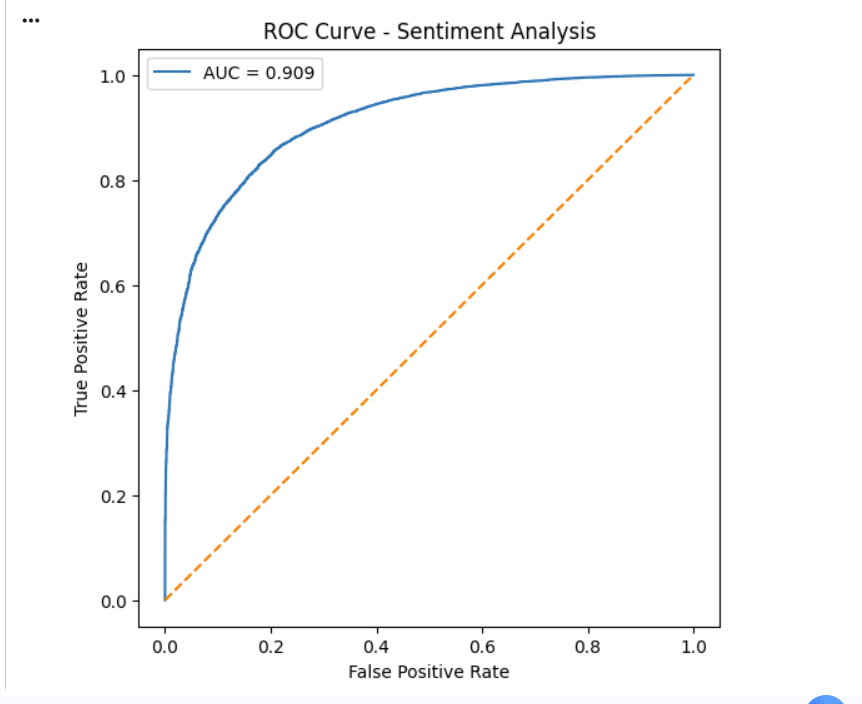

The ROC curve shows the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at different classification thresholds.

The model achieves an AUC of 0.909, which indicates an excellent ability to distinguish between positive and negative reviews.

An AUC of 0.909 means that if we randomly select one positive and one negative review, the model will assign a higher probability score to the positive review approximately 90.9% of the time.

Since the ROC curve lies well above the diagonal baseline (which represents random guessing), this confirms that the model performs significantly better than chance and has strong discriminative power.

Overall, the model demonstrates a high capability to separate positive and negative sentiments effectively.

Next, I would like to experiment with transfer learning using the BERT model. Since BERT has been pre-trained on a very large corpus of data, it has already learned rich contextual representations of language. This means it is capable of understanding semantic and contextual nuances that a simpler model, such as Logistic Regression, may not capture effectively.

By fine-tuning BERT on the sentiment analysis task, the goal is to leverage its pre-trained knowledge to potentially improve classification performance compared to traditional machine learning approaches.

## Transfer learning

Texto → Tokenizer BERT → BERT → Capa lineal → Predicción


In [ ]:
pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install -U transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import f1_score


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
print(device)

cuda


In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[["review", "sentiment_label"]])


In [ ]:
dataset = dataset.rename_column("sentiment_label", "labels")


In [ ]:
def tokenize_function(examples):
  return tokenizer(
      examples["review"],
      padding="max_length",  #Pad all sequences to exactly 128 tokens so they can be processed in batches
      truncation=True,
      max_length=128
  )
dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/99959 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)



In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "f1_macro": f1_score(labels, preds, average="macro")
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,  #After training, automatically reload the checkpoint with the best validation metric instead of the last one.
    metric_for_best_model="f1_macro"
)


In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
     data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [ ]:
print(len(dataset["train"]))


79967


In [ ]:
import torch
print("cuda available:", torch.cuda.is_available())
print("device:", next(model.parameters()).device)


cuda available: True
device: cuda:0


In [ ]:
trainer.train()   #Since executing this on GPU takes approximately two hours,
                  #I have attached screenshots of the results below so that the professor does not need to rerun the training.

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.236975,0.215498,0.872912
2,0.170672,0.247553,0.881595
3,0.103241,0.336603,0.877906


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=14994, training_loss=0.180635586601584, metrics={'train_runtime': 3398.3101, 'train_samples_per_second': 70.594, 'train_steps_per_second': 4.412, 'total_flos': 7944765351243264.0, 'train_loss': 0.180635586601584, 'epoch': 3.0})

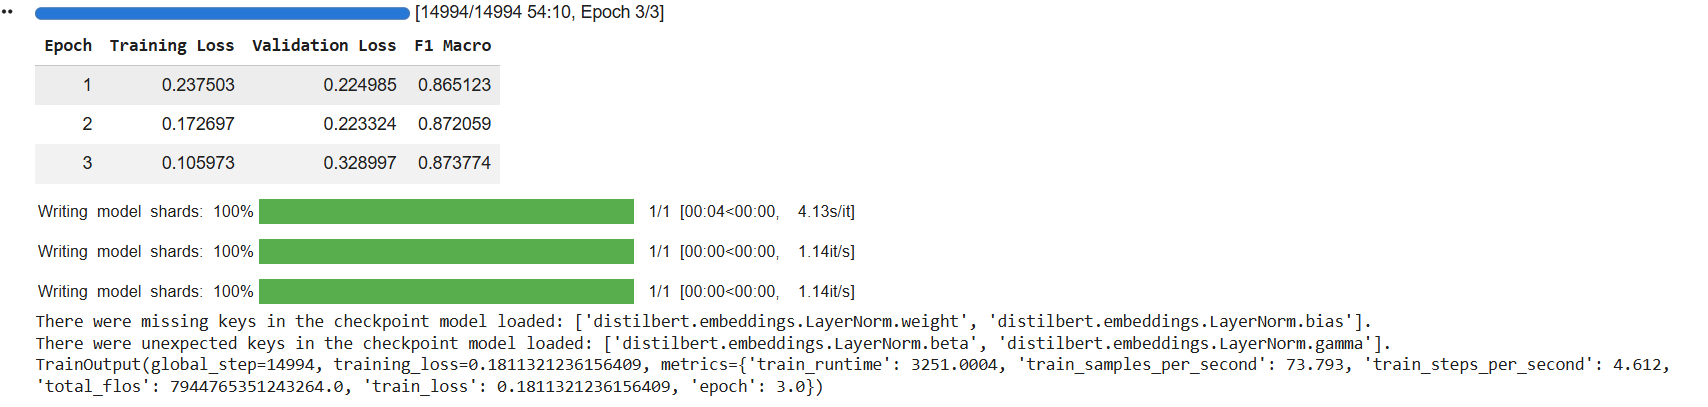

In [ ]:
trainer.evaluate()

{'eval_loss': 0.24751104414463043,
 'eval_f1_macro': 0.881532071319733,
 'eval_runtime': 89.2476,
 'eval_samples_per_second': 224.006,
 'eval_steps_per_second': 14.006,
 'epoch': 3.0}

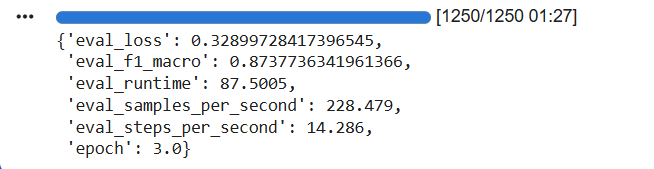

In [ ]:
predictions = trainer.predict(dataset["test"])


In [ ]:
import numpy as np

logits = predictions.predictions
y_pred = np.argmax(logits, axis=1)
y_true = predictions.label_ids


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.81      0.82      4431
           1       0.95      0.95      0.95     15561

    accuracy                           0.92     19992
   macro avg       0.88      0.88      0.88     19992
weighted avg       0.92      0.92      0.92     19992



Con pocos datos, el transfer learning da un resultado horrible. Basicamente ha decidido poner positivo en todos los casos y consecuentemente no acierta ninguno en la clase 0. Con pocos datos, un modelo grande puede sobreajustar o no adaptarse bien, mientras que TF-IDF + modelo simple es más estable.

Con el transfer learning:

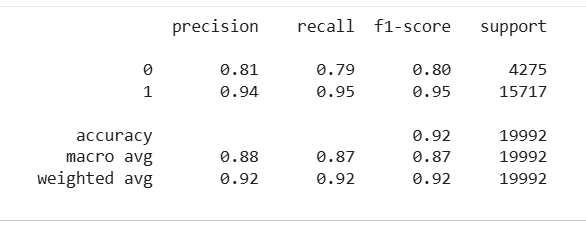

With transfer learning, there has been a significant improvement, particularly in the precision of class 0. The DistilBERT model allows for a better understanding of the contextual meaning of each sentence. As a result, the model is able to capture more nuanced linguistic patterns, which leads to improved classification performance.

In [ ]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(dataset["test"], batch_size=16)

In [ ]:
dataset["test"].set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

from torch.utils.data import DataLoader

test_dataloader = DataLoader(dataset["test"], batch_size=16)

y_scores = []
y_true_list = []

model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
        }

        outputs = model(**inputs)  #Unpack this dictionary as keyword arguments
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        y_scores.extend(probs[:, 1].cpu().numpy())
        y_true_list.extend(batch["labels"].cpu().numpy())

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true_list, y_scores)
roc_auc = auc(fpr, tpr)

In [ ]:
print("AUC:", roc_auc)

AUC: 0.9618657674282519


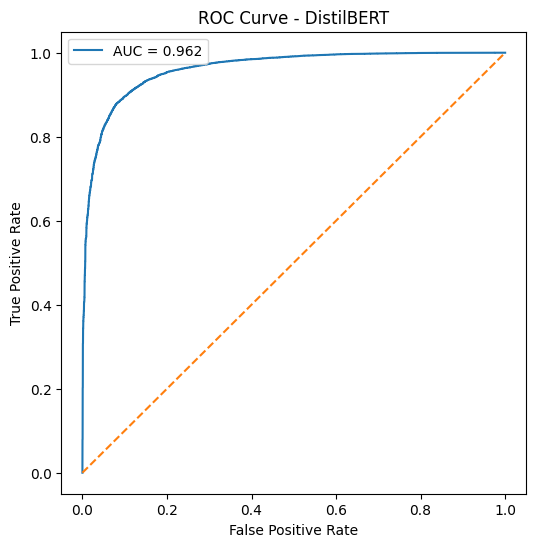

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DistilBERT")
plt.legend()
plt.show()

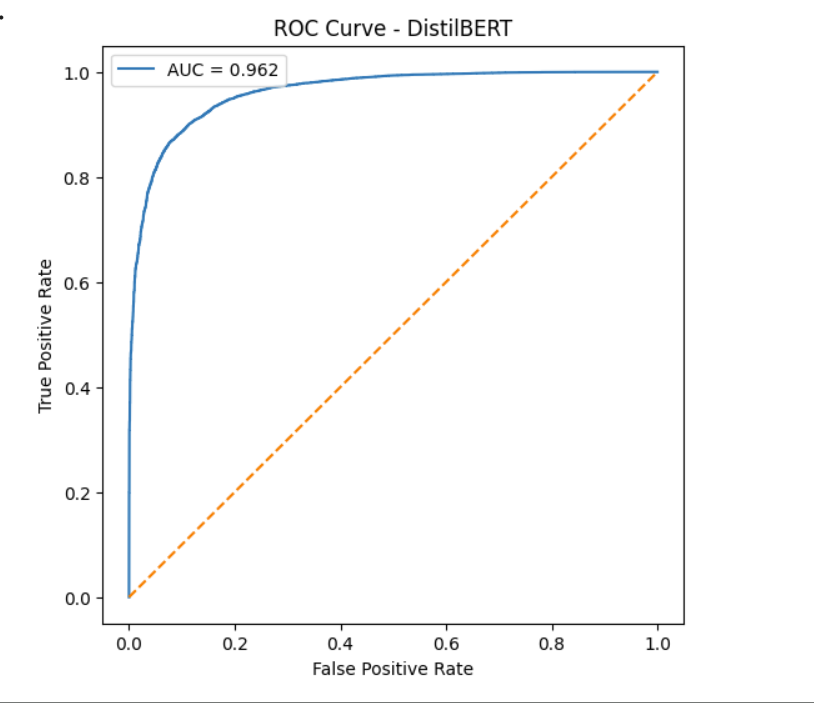

In my case, the transfer learning model seems to perform better at the chosen threshold, especially in detecting the minority class, which improves recall and therefore F1-score.
However, the overall ranking of predicted probabilities across all thresholds may be less well separated, which can lead to a lower ROC-AUC.

# Conclusion

While transfer learning can significantly improve model performance, it also substantially increases computational costs — particularly in terms of GPU usage and memory consumption.

In practice, this forces us to carefully evaluate the trade-off between performance and operational cost.

DistilBERT, for example, contains tens of millions of parameters, which implies:

🔹 Greater infrastructure requirements

🔹 Longer training times

🔹 Higher cloud and energy costs

🔹 Increased deployment and maintenance complexity

Therefore, choosing a Transformer-based model should not be a purely technical decision. It should be a strategic one, aligned with business objectives, scalability constraints, and expected ROI.

In many real-world scenarios, the most sophisticated model is not necessarily the most efficient or economically justified solution.